# Driver Lifetime Value
source: https://platform.stratascratch.com/data-projects/driver-lifetime-value

### Assumptions
(1) The data is from 2016-03 to 2026-06. It is typically not enough duration to observe the life time of the driver. However, given limited data, I assume the life time of all drivers are observed within this period

(2) Without knowing how much revenue is paid back to the driver, I assumn the life time value of the driver is the total revenue generated by the driver

In [19]:
import pandas as pd
import numpy as np
import seaborn as sns

In [3]:
driver = pd.read_csv("./datasets/driver_ids.csv")
ride = pd.read_csv("./datasets/ride_ids.csv")
ridets = pd.read_csv("./datasets/ride_timestamps.csv")

print(driver.info())
print(ride.info())
print(ridets.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 937 entries, 0 to 936
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   driver_id            937 non-null    object
 1   driver_onboard_date  937 non-null    object
dtypes: object(2)
memory usage: 14.8+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193502 entries, 0 to 193501
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   driver_id        193502 non-null  object
 1   ride_id          193502 non-null  object
 2   ride_distance    193502 non-null  int64 
 3   ride_duration    193502 non-null  int64 
 4   ride_prime_time  193502 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 7.4+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 970405 entries, 0 to 970404
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     -

### (1) Feature engineering

In [4]:
# Pivot ride timestamps
ridets["timestamp"] = pd.to_datetime(ridets["timestamp"])
ridets_pivot = (
    ridets.pivot(index="ride_id", columns="event", values="timestamp")
    .reset_index()
    .assign(
        request_to_accept=lambda x: (x.accepted_at - x.requested_at).dt.total_seconds(),
        pickup_to_dropoff=lambda x: (x.dropped_off_at - x.picked_up_at)
        / pd.Timedelta(minutes=1),
    )
)


In [5]:
# Merge driver, ride and ride_ts
trips = ride.merge(ridets_pivot, on="ride_id", how="inner", validate="1:1").merge(
    driver, on="driver_id", how="inner", validate="m:1"
)
print(f"{driver.shape=} {ride.shape=} {ridets_pivot.shape=} {trips.shape=}")

driver.shape=(937, 2) ride.shape=(193502, 5) ridets_pivot.shape=(194081, 8) trips.shape=(184209, 13)


In [6]:
# Calculate fares
trips = trips.assign(
    bare_fare=lambda x: (
        2 + 0.22 * x.ride_duration / 60 + 1.15 * x.ride_distance / 1609.34
    )
    * (100 + x.ride_prime_time)
    / 100
    + 1.75,
    final_fare=lambda x: np.minimum(400, np.maximum(5, x.bare_fare)),
)


In [7]:
print(f"{trips.driver_onboard_date.min()=}")
print(f"{trips.dropped_off_at.max()=}")

trips.driver_onboard_date.min()='2016-03-28 00:00:00'
trips.dropped_off_at.max()=Timestamp('2016-06-27 00:50:50')


In [8]:
trips.columns

Index(['driver_id', 'ride_id', 'ride_distance', 'ride_duration',
       'ride_prime_time', 'accepted_at', 'arrived_at', 'dropped_off_at',
       'picked_up_at', 'requested_at', 'request_to_accept',
       'pickup_to_dropoff', 'driver_onboard_date', 'bare_fare', 'final_fare'],
      dtype='object')

In [10]:
# Active days
# Total trips
# Total distance
# Total duration
# Total prime time
# Total fare
# Tenure
# pct_active
# Average trips per day
# Average distance per day
# Average duration per day
# Average distance per trip
# Average prime time per day
# Average speed
# Dominant working hours: Morning, Afternoon, Evening, Night

driveragg = (
    trips.assign(
        active_date=lambda x: x.accepted_at.dt.date,
        driver_onboard_date=lambda x: pd.to_datetime(x.driver_onboard_date),
        tenure=lambda x: (pd.to_datetime("2016-06-30") - x.driver_onboard_date).dt.days,
        prime_trip=lambda x: np.where(x.ride_prime_time > 0, 1, 0),
    )
    .groupby(["driver_id", "tenure"], as_index=False)
    .agg(
        driver_onboard_date=("driver_onboard_date", "min"),
        active_days=("active_date", "nunique"),
        last_active_day=("accepted_at", "max"),
        total_trips=("ride_id", "nunique"),
        total_distance=("ride_distance", "sum"),
        total_duration=("ride_duration", "sum"),
        total_fare=("final_fare", "sum"),
        total_prime=("ride_prime_time", "sum"),
        total_prime_trip=("prime_trip", "sum"),
    )
    .assign(
        lifetime=lambda x: (x.last_active_day - x.driver_onboard_date).dt.days,
        pct_active=lambda x: x.active_days / x.tenure,
        pct_prime=lambda x: x.total_prime_trip / x.total_trips,
        trips_pday=lambda x: x.total_trips / x.active_days,
        distance_pday=lambda x: x.total_distance / x.active_days,
        duration_pday=lambda x: x.total_duration / x.active_days,
        distance_ptrip=lambda x: x.total_distance / x.total_trips,
        prime_pday=lambda x: x.total_prime / x.active_days,
        fare_ptenure=lambda x: x.total_fare / x.tenure,
        primetrip_pday=lambda x: x.total_prime_trip / x.active_days,
    )
)

In [241]:
driveragg.columns

Index(['driver_id', 'tenure', 'driver_onboard_date', 'active_days',
       'last_active_day', 'total_trips', 'total_distance', 'total_duration',
       'total_fare', 'total_prime', 'total_prime_trip', 'lifetime',
       'pct_active', 'trips_pday', 'distance_pday', 'duration_pday',
       'distance_ptrip', 'prime_pday', 'fare_ptenure', 'primetrip_pday'],
      dtype='object')

### (2) Driver lifetime value

In [11]:
driveragg.total_fare.mean()

2979.8596114979996

### (3) Average life time

In [12]:
print(f"{driveragg.lifetime.mean()} days")

55.075268817204304 days


### (3) CATGBM to predict total lifetime value

In [15]:
target = "total_fare"
predictors = [
    "pct_active",
    "pct_prime",
    "trips_pday",
    "distance_pday",
    "duration_pday",
    "distance_ptrip",
    "prime_pday",
    "fare_ptenure",
    "primetrip_pday",
]

<Axes: >

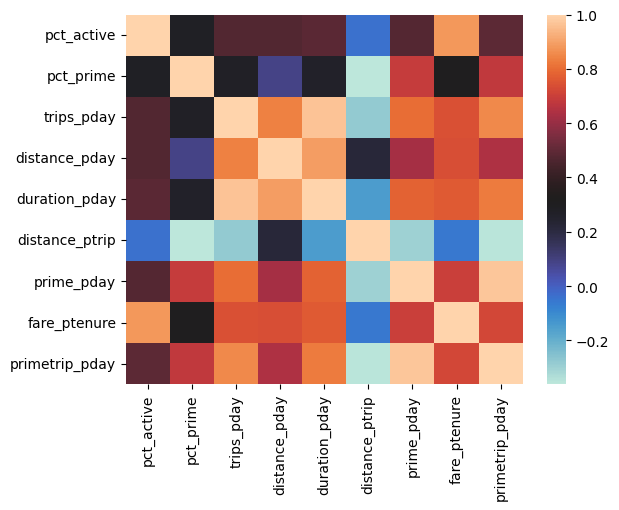

In [24]:
preddf = driveragg[predictors]
corrmap = preddf.corr()
sns.heatmap(corrmap, cmap="icefire")